In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX

import math

# sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/nfshome/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list
     
import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
dirs = {}

dirs['ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/'

dirs['ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/'
 

out_dir = '/nfshome/jmao/cms-llp/plots/20190919/'

fnames = {}

fname = {
    'ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root',
    'ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root',

        }

texs = {}

texs['ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root'] = 'ctau = 10000 mm, W(lv)H(bb)'
texs['ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root'] = 'cms, W(lv)H(bb)'


cols = {}

 
cols['ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root'] = 215
cols['ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root'] = 207


styles = {}

styles['ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root'] = 3
styles['ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root'] = 4

tree = OrderedDict()

for file in fname:
    print(dirs[file]+file)
 
    root_dir = uproot.open(dirs[file]+file) 
    tree[file] = root_dir['ntuples/llp']
 
    print ('Open ready')
    print(texs[file])
    print ('Tree ready') 
    print(tree[file], tree)

/mnt/hadoop/store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root
Open ready
cms, W(lv)H(bb)
Tree ready
<TTree b'llp' at 0x7f41b06ac978> OrderedDict([('ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root', <TTree b'llp' at 0x7f41b06ac978>)])
/mnt/hadoop/store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root
Open ready
ctau = 10000 mm, W(lv)H(bb)
Tree ready
<TTree b'llp' at 0x7f41b06acef0> OrderedDict([('ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root', <TTree b'llp' at 0x7f41b06ac978>), ('ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root', <TTree b'llp' at 0x7f41b06acef0>)])


# LHE Comments  --- Higgs Pt

ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root <TTree b'llp' at 0x7f41b06ac978>
ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root <TTree b'llp' at 0x7f41b06acef0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190919/lhe_h_pt.png has been created


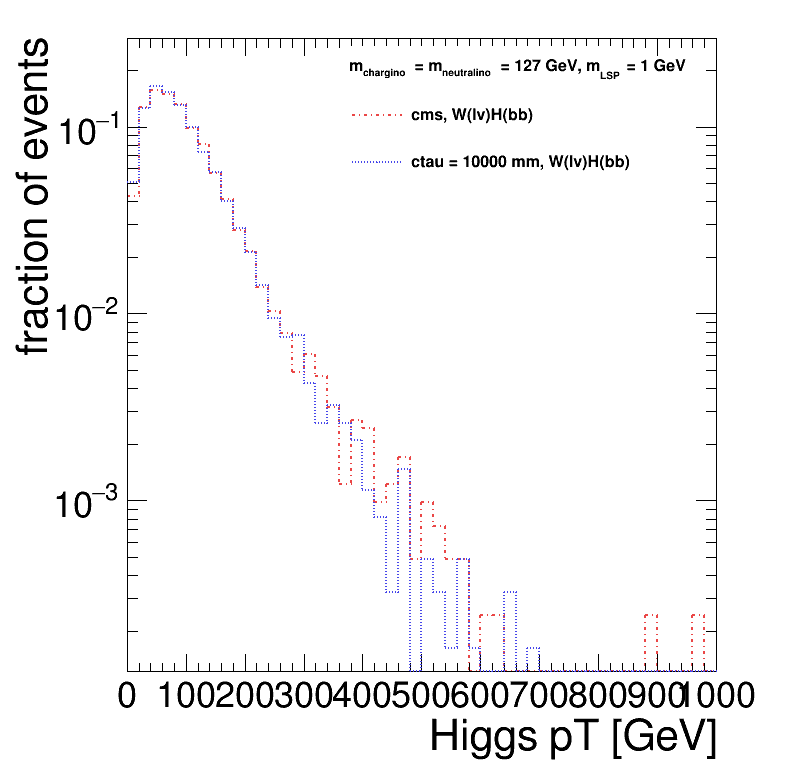

In [4]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    

    
    
    if 'cms' in k:
        
        #branches
    
        pid = v['gParticleId'].array()
        status = v['gParticleStatus'].array()
        pt = v['gParticlePt'].array()
        lhe = v['lheComments'].array()

        basic_str = np.logical_and(pid==25, status==22)


        tags = []

        for i,x in enumerate(lhe):
            cfg = str(x, 'utf-8')
            tags.append(cfg)

        tags = np.array(tags)
        
#         print(tags[:10])
#         print(np.unique(tags))
    
        # variables
    
        lhe_str = np.logical_and(1,  tags=='TChiWH_WToLNu_HToBB_127_1')
        cut_str = np.logical_and(lhe_str, basic_str)
    
        h_pt = pt[cut_str]
        
        #plotting

        h_pt_all = h_pt.flatten()

#         print(h_pt_all[:10])
#         print(pt[:10])

        ht[k] = create_TH1D( h_pt_all, axis_title=['Higgs pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        ht[k].SetLineStyle(styles[k])
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], texs[k])

        i += 1


    elif 'aod' in k:
        
        #branches
    
        pid = v['gParticleId'].array()
        status = v['gParticleStatus'].array()
        pt = v['gParticlePt'].array()
        lhe = v['lheComments'].array()

        basic_str = np.logical_and(pid==25, status==22)


        tags = []

        for i,x in enumerate(lhe):
            cfg = str(x, 'utf-8')
            tags.append(cfg)

        tags = np.array(tags)
    
#         print(tags[:10])
#         print(pt[:10])
    
        # variables
        
        h_pt = pt[basic_str]
        
        #plotting

        h_pt_all = h_pt.flatten()

#         print(h_pt_all[:10])

        ht[k] = create_TH1D( h_pt_all, axis_title=['Higgs pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        ht[k].SetLineStyle(styles[k])
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], texs[k])

        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'lhe_h_pt.png')

ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root <TTree b'llp' at 0x7f41b06ac978>
['TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200']
[ 91.29153   47.8884    97.75333   30.665804  43.046726  52.608147
 285.46094  145.35779   70.457504 184.63742 ]
ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root <TTree b'llp' at 0x7f41b06acef0>
['TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000']
[344.02505  141.104   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


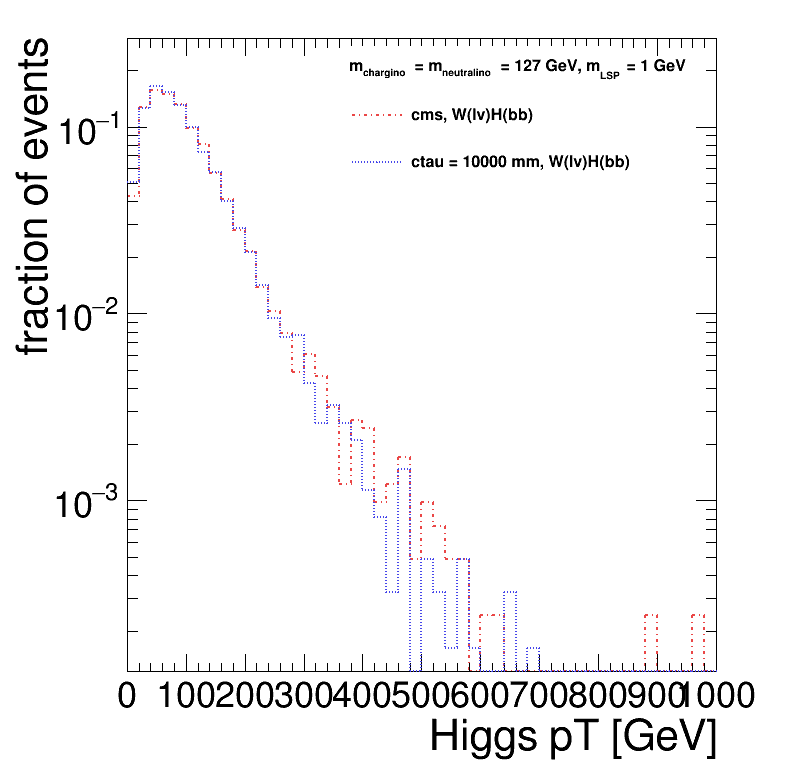

In [5]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    #branches

    pid = v['gParticleId'].array()
    status = v['gParticleStatus'].array()
    pt = v['gParticlePt'].array()
    lhe = v['lheComments'].array()

    basic_str = np.logical_and(pid==25, status==22)


    tags = []

    for i,x in enumerate(lhe):
        cfg = str(x, 'utf-8')
        tags.append(cfg)

    tags = np.array(tags)

    print(tags[:10])

    # variables
    
    
    if 'cms' in k:  
    
        lhe_str = np.logical_and(1,  tags=='TChiWH_WToLNu_HToBB_127_1')
        cut_str = np.logical_and(lhe_str, basic_str)
    
        h_pt = pt[cut_str]


    elif 'aod' in k:
        

        h_pt = pt[basic_str]
        
    #plotting

    h_pt_all = h_pt.flatten()

    print(h_pt_all[:10])

    ht[k] = create_TH1D( h_pt_all, axis_title=['Higgs pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(styles[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], texs[k])

    i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'lhe_h_pt.png')

# LHE Comments --- MET

ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root <TTree b'llp' at 0x7f41b06ac978>
ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root <TTree b'llp' at 0x7f41b06acef0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190919/met.png has been created


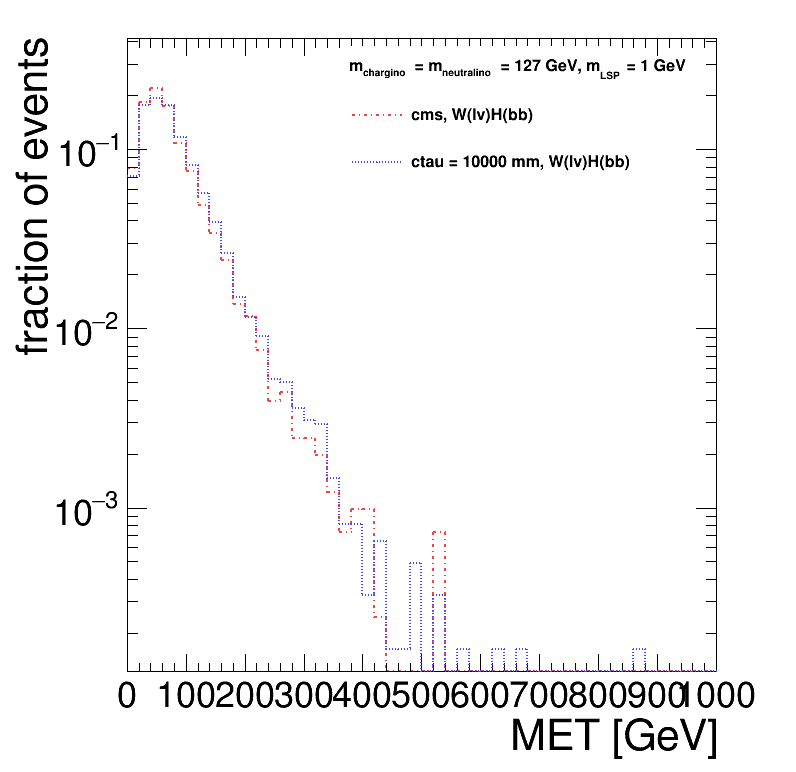

In [6]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    #branches
    
    pid = v['gParticleId'].array()
    status = v['gParticleStatus'].array()
    pt = v['gParticlePt'].array()
    lhe = v['lheComments'].array()
    met = v['genMetPtCalo'].array()
    

    tags = []
    
    for i,x in enumerate(lhe):
        cfg = str(x, 'utf-8')
        tags.append(cfg)
        
    tags = np.array(tags)
    
    # variables
    
    if 'cms' in k:
    
        lhe_str = np.logical_and(1,  tags=='TChiWH_WToLNu_HToBB_127_1')
    
        met = met[lhe_str]

        
    #plotting


    ht[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(styles[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], texs[k])

    i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met.png')

# LHE Comments --- N2 Pt

ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root <TTree b'llp' at 0x7f41b06ac978>
['TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200']
[ 88.115685  51.768654 100.185524  41.411743  33.34274   53.660477
 300.72922  118.82329   65.50704  183.9263  ]
ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root <TTree b'llp' at 0x7f41b06acef0>
['TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000']
[339.643    136.63081 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190919/lhe_n2_pt.png has been created


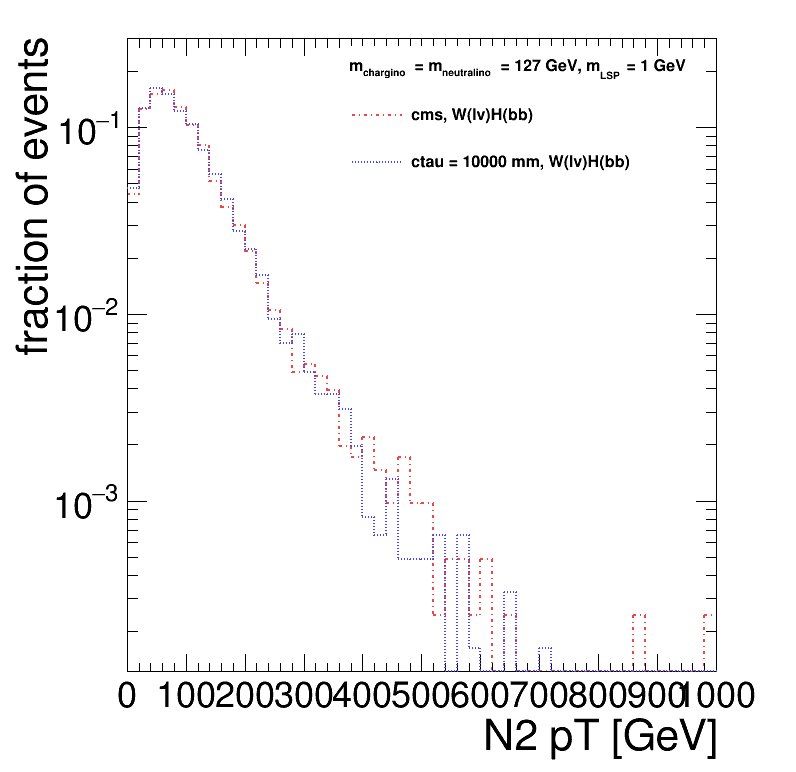

In [9]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    #branches

    pid = v['gParticleId'].array()
    status = v['gParticleStatus'].array()
    pt = v['gParticlePt'].array()
    lhe = v['lheComments'].array()

    basic_str = np.logical_and(pid==1000023, status==22)


    tags = []

    for i,x in enumerate(lhe):
        cfg = str(x, 'utf-8')
        tags.append(cfg)

    tags = np.array(tags)

    print(tags[:10])

    # variables
    
    
    if 'cms' in k:  
    
        lhe_str = np.logical_and(1,  tags=='TChiWH_WToLNu_HToBB_127_1')
        cut_str = np.logical_and(lhe_str, basic_str)
    
        h_pt = pt[cut_str]


    elif 'aod' in k:
        

        h_pt = pt[basic_str]
        
    #plotting

    h_pt_all = h_pt.flatten()

    print(h_pt_all[:10])

    ht[k] = create_TH1D( h_pt_all, axis_title=['N2 pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(styles[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], texs[k])

    i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'lhe_n2_pt.png')

ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root <TTree b'llp' at 0x7f41b06ac978>
['TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200']
[0.73381406 1.6357139  0.6973099  1.2046075  1.5400771  0.66059315
 2.6972659  1.5713785  1.0681366  2.5695744 ]
[ 0.04573677  0.06588626  0.06951521 ... 14.88099    14.961957
 27.184826  ]
ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root <TTree b'llp' at 0x7f41b06acef0>
['TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190919/lhe_n1_from_n2_pt.png has been created


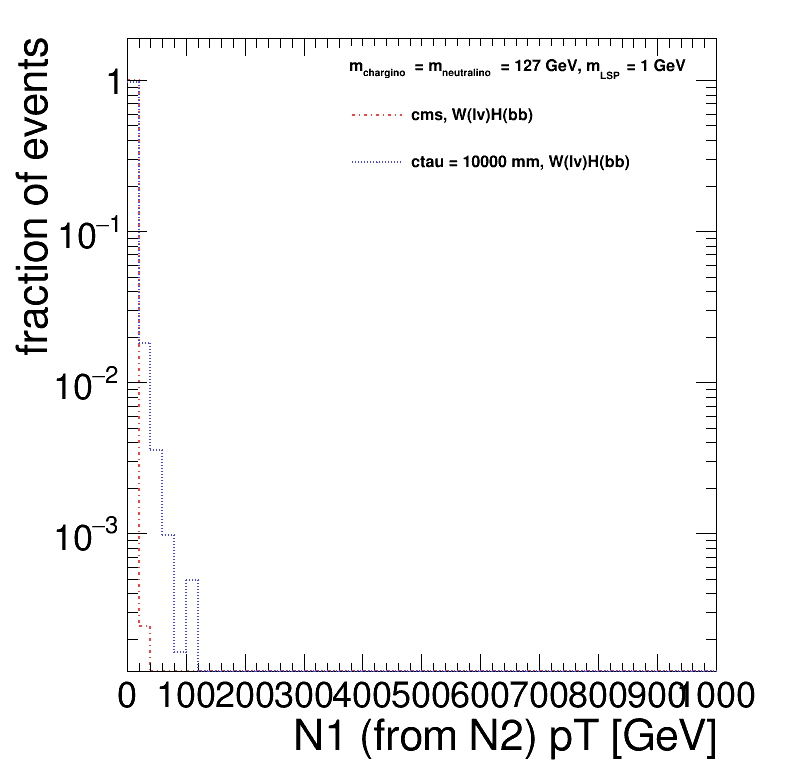

In [8]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    #branches

    pid = v['gParticleId'].array()
    mid = v['gParticleMotherId'].array()
    status = v['gParticleStatus'].array()
    pt = v['gParticlePt'].array()
    lhe = v['lheComments'].array()

    basic_str = np.logical_and(pid==1000022, mid==1000023)


    tags = []

    for i,x in enumerate(lhe):
        cfg = str(x, 'utf-8')
        tags.append(cfg)

    tags = np.array(tags)

    print(tags[:10])

    # variables
    
    
    if 'cms' in k:  
    
        lhe_str = np.logical_and(1,  tags=='TChiWH_WToLNu_HToBB_127_1')
        cut_str = np.logical_and(lhe_str, basic_str)
    
        h_pt = pt[cut_str]


    elif 'aod' in k:
        

        h_pt = pt[basic_str]
        
    #plotting

    h_pt_all = h_pt.flatten()

    print(h_pt_all[:10])
    print(np.unique(h_pt_all))

    ht[k] = create_TH1D( h_pt_all, axis_title=['N1 (from N2) pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(styles[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], texs[k])

    i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'lhe_n1_from_n2_pt.png')

ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_cms_lhe.root <TTree b'llp' at 0x7f41b06ac978>
['TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200'
 'TChiWH_WToLNu_HToBB_350_200' 'TChiWH_WToLNu_HToBB_350_200']
[]
[]
ntuple_RunIISummer16_SUS-RunIIFall17FSPremix-00057_TCHI_WH_V2_aod_lhe.root <TTree b'llp' at 0x7f41b06acef0>
['TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000'
 'TChiWH_WToLNu_HToBB_127_1_10000' 'TChiWH_WToLNu_HToBB_127_1_10000']
[]
[]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Error in <TH1D::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: 
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190919/lhe_n1_from_n3_pt.png has been created


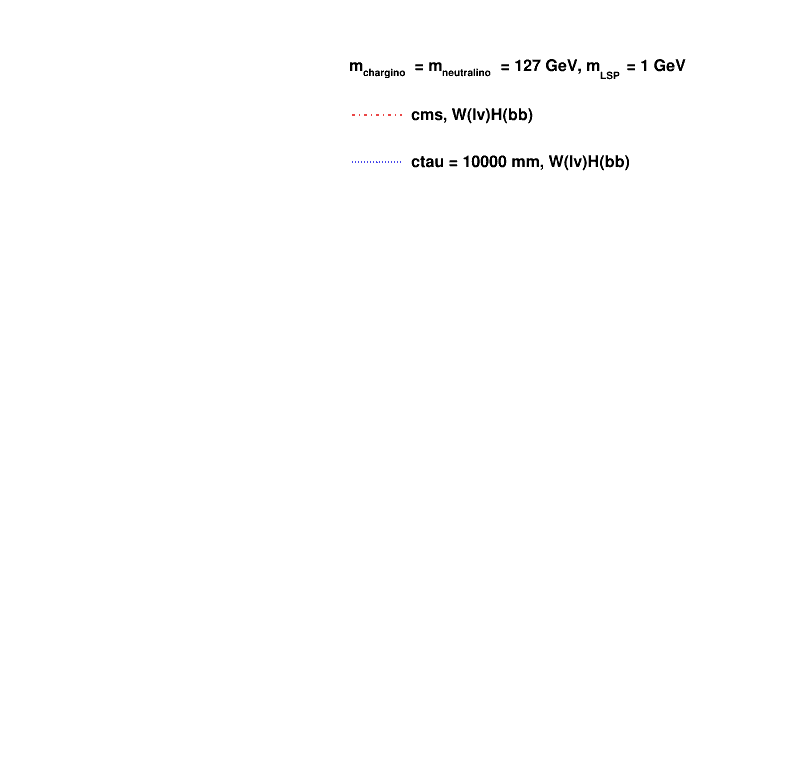

In [11]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    #branches

    pid = v['gParticleId'].array()
    mid = v['gParticleMotherId'].array()
    status = v['gParticleStatus'].array()
    pt = v['gParticlePt'].array()
    lhe = v['lheComments'].array()

    basic_str = np.logical_and(pid==1000022, mid==1000025)


    tags = []

    for i,x in enumerate(lhe):
        cfg = str(x, 'utf-8')
        tags.append(cfg)

    tags = np.array(tags)

#     print(tags[:10])

    # variables
    
    
    if 'cms' in k:  
    
        lhe_str = np.logical_and(1,  tags=='TChiWH_WToLNu_HToBB_127_1')
        cut_str = np.logical_and(lhe_str, basic_str)
    
        h_pt = pt[cut_str]


    elif 'aod' in k:
        

        h_pt = pt[basic_str]
        
    #plotting

    h_pt_all = h_pt.flatten()

    print(h_pt_all[:10])
    print(np.unique(h_pt_all))

    ht[k] = create_TH1D( h_pt_all, axis_title=['N1 (from N3) pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
    ht[k].SetLineStyle(styles[k])
    ht[k].SetLineColor(cols[k])
    ht[k].SetMarkerColor(cols[k])

    ht[k].DrawNormalized('same')

    leg.AddEntry(ht[k], texs[k])

    i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'lhe_n1_from_n3_pt.png')